<a href="https://colab.research.google.com/github/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/06-Gromacs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 6
**Introduction to GROMACS**


Authors:
    
- Prof. Marco A. Deriu (marco.deriu@polito.it)
- Lorenzo Pallante (lorenzo.pallante@polito.it)
- Eric A. Zizzi (eric.zizzi@polito.it)
- Marcello Miceli (marcello.miceli@polito.it)
- Marco Cannariato (marco.cannariato@polito.it)

# Table of Contents

1. Gromacs Setup
2. Molecular Dynamics (MD) Flow chart
3. GROMACS 1 (make_ndx, editconf, pdb2gmx)
4. GROMACS 2 (editconf, solvate, grompp, genion)
5. GROMACS 3 (grompp, mdrun, energy)
6. GROMACS 4 (analysis)

**Learning outcomes:**
- how to install gromacs and lauch it
- General flow chart of a MD simulation
- GROMACS:
    - create an index file
    - generate a simulation box
    - create gmx starting files
    - prepare the simulation box
    - generate the environment: solvent and ions
    - equilibrate the system
    - perform classical MD simulation
    - perform basic analysis

# Setup

If you don't have GROMACS and NGLView installed on your machine or if you are using Google COLAB, run the following lines

**This lines should be run at the beginning of each laboratory**

In [1]:
#@title Increase the output length
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10000000})

In [2]:
#@title Installing GROMACS and related packages
!apt install gromacs &> /dev/null
!apt install dssp &> /dev/null
!ln -s /usr/bin/dssp /usr/local/bin/dssp
!apt install ghostscript &> /dev/null

In [3]:
#@title Installing NGLview
!pip install nglview  &> /dev/null
!pip install simpletraj  &> /dev/null
!pip install mdanalysis &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

Clone files form GitHub if you are using COLAB

In [4]:
# IF YOU ARE USING COLAB EXECUTE THIS CELL (to copy over data repository)
!git clone https://github.com/lorenzopallante/BiomeccanicaMultiscala.git
!mv BiomeccanicaMultiscala/LAB/06-Gromacs/* .

Cloning into 'BiomeccanicaMultiscala'...
remote: Enumerating objects: 1627, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 1627 (delta 248), reused 382 (delta 229), pack-reused 1224 (from 1)
Receiving objects: 100% (1627/1627), 219.07 MiB | 28.81 MiB/s, done.
Resolving deltas: 100% (828/828), done.
Updating files: 100% (347/347), done.


# Introduction

**GROMACS is a major free, open-source, and fast code developed for Molecular Dynamics (MD) simulations**. Its continuous updates (1 major release/year), speed, efficiency and flexibility, along with the inbuilt availability of force fields specific for proteins, make it one of the most popular choices for biomolecular simulations.
(http://www.gromacs.org/).

Complete **GROMACS tutorial** available at: http://www.mdtutorials.com/gmx/

To see what gromacs version is installed on your PC:

In [5]:
!gmx -version

                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

All gromacs commands can be used with the syntax:

`
    gmx <command>
`

And all the commands have a help message that can be displayed using the option “-h”, e.g.:

`
    gmx pdb2gmx -h    
`

For basic and advanced GROMACS tutorial, please visit: http://www.mdtutorials.com/gmx/


## Files and suggested directory tree
You will need the following files to run a simulation:
>1. Atom coordinates: *.pdb (or *.gro)
>2. Topology file: *.top
>3. MD parameters: *.mdp

**1. PDB**
- coordinates of atoms in the x,y,z space
- see also the lesson *03-Intro_LinuxBash* for further info

![title](https://github.com/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/imgs/pdb.png?raw=1)

**2. TOP**
- topology of the systems, i.e. bonds, angles, diehedrals, non-bonded interactios and relative parameters
- generated by GROMACS once you select the forcefield (or made by yourself when you're a pro!)


<img src="https://github.com/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/imgs/top2.png?raw=1" width="1200" align="center">

**3. MDP**
- simulation parameters, such as integration time step, simulation duration, cut-off, temperature and pressure couplings, etc..

![mdp](https://github.com/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/imgs/mdp.png?raw=1)

*We suggest you create a new folder for each simulation you run, put all the necessary files into the simulation folder itself, and let GROMACS write into that same folder.*

<div class="alert alert-block alert-warning">

Keep in mind that GROMACS is a **command-line program**:
    
if you don’t specify the full paths to the required input files, but only the file name (example call: $ gmx make_ndx -s struct.tpr -o index.ndx ), GROMACS will expect the input file (struct.tpr) to be in the folder you’re calling it from, and will write the output file (index.ndx) into the same current folder. If struct.tpr is not in the current folder, GROMACS will throw an error and fail! GROMACS error messages are pretty explicit, so chances are READING THE ERROR is enough to troubleshoot most issues (e.g. if a required file is missing).

<div/>

## Molecule: Cell-Penetrating Peptide

The discovery of Cell-Penetrating Peptides (CPPs) represents an important breakthrough for the delivery of large cargo molecules or nanoparticles for several clinical applications. A main feature of CPPs is the ability to
penetrate the cell membrane at low micromolar concentrations in vivo and in vitro, without binding any chiralreceptors and without causing significant membrane damage. This ability offers significant therapeutic potential,
as targeting areas normally difficult to access for drugs.
TAT peptide and Drosophila Antennapedia homeodomain-derived penetratin peptide (pAntp) are the most
extensively studied CPPs. In particular, the pAntp is a 16-residues long cationic peptide derived from the third
helix of the homeodomain of the Drosohila transcription factor Antennapedia. This amphipatic CPP, largely
unstructured in solution, is positively charged at neutral pH (since it contains four lysine and three arginine
residues). Interestingly, the pAntp is able to cross biological membranes and enter a hydrophobic environment
upon interaction with negatively-charged molecules, like phosphatic acid (PA) or phosphatidylserine (PS).
However, mechanisms by which pAntp comes into the cells have not been completely understood. Proposed
mechanisms of pAntp cellular uptake hypothesize direct crossing of the peptide through the membrane at low
peptide concentrations (1μM) and an endocytotic pathway at high concentrations (10μM). Several studies have
suggested that pAntp amphiphilicity may not be enough to drive the membrane penetration, indicating instead
tryptophan as key player. Replacement of thryptophan by phenylanine resulted in a loss of penetration activity
when interacting with membranes and bicelles. Moreover, a recent computational work has characterized the
binding mode of pAntp-DPPC bilayers, proposing arginine, lysine and tryptophan as driving the penetration
mechanism.
This extraordinary ability of CPPs to penetrate cell membranes has brought to designate them as perfect
functionalization molecules for drug delivery systems.
For example, pAntp might be employed to decorate Magnetic Nanoparticles (MNPs), thus combining their
fascinating physico-chemical properties with a cell-penetrating ability to design novel effective therapeutic
strategies as well as innovative biotechnology methodologies. Size, biocompatibility and excellent magnetic
properties, have made MAG and Silica-coated MAG the object of a remarkable amount of research in the last
decade and numerous biomedical applications have been reported. Recently, MNPs combined with magnetic
fields were used to enable cell positioning under non-permissive conditions, local gene therapy and/or
optimization of MNP- assisted lentiviral gene transfer.
Functionalization strategies comprise grafting with organic molecules, including small organic biomolecules such
as CPPs, and/or coating with an inorganic layer (e.g., silica).
Design and properties prediction of functionalization strategies may be addressed by computational molecular
modelling. In this context, Kubiak-Ossowska and coworkers have recently employed computational modelling
to investigate the adsorption of TAT peptides onto three silica surface models. This work has suggested that TAT-
Silica adsorption mechanism is driven by electrostatic and hydrophobic interactions mainly involving arginine
residues and the nanoparticle surface.

## Molecular Dynamics (MD) Simulations

Briefly, the general workflow of an MD simulation with GROMACS is
divided in the following steps (see also “MD_FlowChart.pdf”):

1. System Preparation
> - Retrieve starting structure (e.g. RCSB)
> - GROMACS structure conversion (from pdb to gro*)
>- Topology (and position restraints) generation
>- System box generation and addition of water and ions

2. Energy Minimization
3. Simulation
> - (Equilibration: Molecular Dynamics Simulation normally with position restraints)
> - Production: Molecular Dynamics Simulation

4. Analysis of the Simulation

*note that both .gro and .pdb files both contain atomic coordinates and
only differ for minor aspects:
> - .gro coordinates are in nm, whereas *.pdb coordinates in Å
> - .gro file can contain also atoms’ velocities

GROMACS can work with both types of files and does not strictly need the .gro file format for most operations.
It can be however handy to have a .gro file, for example, to quickly extract the box vector.

<img src="https://github.com/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/imgs/MD_FlowChart.png?raw=1" width="500" align="center">

# PART 1 – PDB conversion

The protein of interest for the present tutorial is called penetratin.pdb (already present in the data/ folder)

Using a visualization software (for example VMD, PyMol, UCSF Chimera, Schrödinger Maestro, MOE, ...) you can view and rotate the structure. Here we will use **NGL View** for semplicity.

In [6]:
import nglview as nv
from IPython.display import IFrame

with open("data/penetratin.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

Let’s now have a look at the actual pdb file, which is nothing more than a text file!

In [7]:
!cat data/penetratin.pdb

TITLE     Penetratin-Silica Umbrella simulation in water
REMARK    THIS IS A SIMULATION BOX
CRYST1   65.000   65.000   70.000  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1  N   ARG B  43      27.450  39.330  58.820  1.00  0.00           N
ATOM      2  H1  ARG B  43      28.202  39.988  58.773  1.00  0.00            
ATOM      3  H2  ARG B  43      26.584  39.820  58.920  1.00  0.00            
ATOM      4  H3  ARG B  43      27.584  38.726  59.606  1.00  0.00            
ATOM      5  CA  ARG B  43      27.420  38.520  57.570  1.00  0.00           C
ATOM      6  HA  ARG B  43      28.336  38.125  57.501  1.00  0.00            
ATOM      7  CB  ARG B  43      26.210  37.540  57.770  1.00  0.00           C
ATOM      8  HB1 ARG B  43      25.409  38.082  58.024  1.00  0.00            
ATOM      9  HB2 ARG B  43      26.437  36.913  58.515  1.00  0.00            
ATOM     10  CG  ARG B  43      25.810  36.680  56.560  1.00  0.00           C
ATOM     11  HG1 ARG B  43      

You will see that the pdb is essentially a space-separated text file organized into columns.
Briefly:
- The first column defines the row type (e.g. REMARK tells you that this row is a comment, ATOM tells you that this row contains actual atomic coordinates, etc.).
- Columns 7, 8 and 9 contain the x,y,z coordinates of the atoms of the system.

For more information: https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html.

## Make Index File (gmx make_ndx)


We now introduce a very powerful tool in GROMACS: index files. Index files are created starting from an atomic system (e.g. a pdb file), and split atoms into specific groups. These can be useful to restrict operations and analyses only to specific parts of the system, for example, if you want to see fluctuations of the alpha-Carbons only, you can select that specific group in the analysis tool.

To have detailed information about the command to make index files, just type:

In [8]:
!gmx make_ndx -h

             :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

Let’s first create an index file (it will not be created by default when you launch the simulation!):

In [9]:
!echo -e "q \n" | gmx make_ndx -f data/penetratin.pdb -o index.ndx

             :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

You will see that make_ndx will read the pdb file (option “-f”), create some default groups and then wait for your input.

You can manually add groups by typing the atoms manually (we will see the selection syntax later on...), or simply accept the default groups and save them by typing q and hitting Enter. The final index file (index.ndx) will be saved with the name chosen in the option “-o”.

## Edit molecular configuration (gmx editconf)

As mentioned, the previous groups obtained with gmx make_ndx can be used to tell GROMACS to do operations on a specific subset of atoms only. Let’s say for example I want a pdb file containing only the alpha Carbons of my starting penetratin.pdb structure. I can achieve this by calling editconf (which, as the name suggests, is an editor for molecular configurations) and also including the index.ndx file as input:

In [10]:
!echo "C-alpha" | gmx editconf -f data/penetratin.pdb -o calpha.pdb -n index.ndx

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

In simpler words, this command is saying:

***“Call the editconf utility, read the penetratin.pdb and the index.ndx files, and write the result to calpha.pdb”***

Have a look to the only c-alpha structure:

In [11]:
with open("calpha.pdb") as f:
    view = nv.show_file(f, ext="pdb")

view.add_representation("hyperball")
view

NGLWidget()

Indeed, editconf will prompt for a group. Choose C-alpha by typing 3 and hitting Enter. Editconf will confirm the selection and write atoms belonging to the C-alpha group to the file calpha.pdb (check it by opening the file with a text editor!). Easy, right?

## Prepare file for Gromacs (gmx pdb2gmx)

We have to generate a **topology** for the system and convert it to the **.gro file format**.

The tool for conversion is **pdb2gmx**. As always, you can use the -h flag to print some help:

In [12]:
!gmx pdb2gmx -h

             :-) GROMACS - gmx pdb2gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

The main options of the **pdb2gmx** tool are:
> - f: input file (coordinates, so .pdb or .gro)
> - p: topology output file (a text file, ending in .top)
> - o: structure output file (coordinates after processing, again .pdb or .gro)
> - i: position restraints output file (.itp)

In [13]:
!gmx pdb2gmx -f data/penetratin.pdb -i penetratin_posre.itp -p penetratin.top -o penetratin.gro -ff amber99sb-ildn  -ignh -heavyh -water tip3p

             :-) GROMACS - gmx pdb2gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Let's have a look at all the options of the program:

- **ff** : forcefield -> The force field will contain the information that will be written to the topology. This is a very important choice! You should always read thoroughly about each force field and decide which is most applicable to your situation.

- **water**: water model chosen among TIP3P, TIP4P, TIP4P-Ew, TIP5P, SPC, SPC/E

- **ignh**: it stands for “ignore hydrogens”, so it will ignore all the hydrogens in the input coordinate file

- **heavyh**: makes hydrogen atoms heavy to reduce oscillation frequency

Have a look at the generated files:

In [14]:
!ls -l

total 264
-rw-r--r-- 1 root root 114010 Dec 13 12:46 06-Gromacs.ipynb
drwxr-xr-x 4 root root   4096 Dec 13 12:46 BiomeccanicaMultiscala
-rw-r--r-- 1 root root   1453 Dec 13 12:48 calpha.pdb
drwxr-xr-x 7 root root   4096 Dec 13 12:46 data
drwxr-xr-x 2 root root   4096 Dec 13 12:46 examples
drwxr-xr-x 2 root root   4096 Dec 13 12:46 imgs
-rw-r--r-- 1 root root   7464 Dec 13 12:48 index.ndx
drwxr-xr-x 2 root root   4096 Dec 13 12:46 materials
-rw-r--r-- 1 root root  15114 Dec 13 12:49 penetratin.gro
-rw-r--r-- 1 root root   5202 Dec 13 12:49 penetratin_posre.itp
-rw-r--r-- 1 root root  94106 Dec 13 12:49 penetratin.top
drwxr-xr-x 1 root root   4096 Dec 11 17:04 sample_data


Have a look at the *.gro file with a text editor to see the differences with the pdb file!

# PART 2 - Preparation of the simulation box and environment

The files obtained at the end of the last laboratory are contained in the folder `data/part_1`. If you have not run the previous part of the notebook, copy those data in the current folder with the following cell:

In [15]:
!cp data/part_1/* .

## Define the simulation box

Now, we defined the parameters and water model to be used in the simulation. The next step in the preparation of the system is to actually put the system in a simulation box with the appropriate shape and dimension.

There are several possible shapes of the unit cell, such as the cubic or the dodecahedron. The dodecahedron is sometimes chosen to simulate globular systems, since its volume is ~71% of the cubic box with the same distance between periodic distance.

The volume of the box must be optimized in real-life problems because it allows to lower the computational cost of the simulation. Indeed, as we will see in the following steps, the box will be filled with water molecules and ions, thus increasing exponentially the number of atoms in the system.

<div class="alert alert-block alert-info"><b>Which terms of the potential energy definition are linked to the exponential growth of the computational cost with the number of atoms in the system?</b></div>

In this tutorial, we will put our protein in the center of a cubic box big enough to have a minimum distance between the protein and the box wall of 0.8 nm.

<center> <div class="alert alert-block alert-info"><b>Is this distance enough to respect the minimum image convention?</b></div>

The GROMACS command that allows us to do this operation is:
```bash
$ gmx editconf -f penetratin.gro -o box.gro -c -d 0.8 -bt cubic
```
the above command take the atoms in the file `penetratin.gro`, places the origin of the reference system at their center (`-c`), then builds around them a cubic box (`-bt cubic`) with the constraint that the minimum distance between the atoms of the system and the box wall is 0.8 nm (`-d 0.8`).

The `editconf` command allows to manipulate the molecular systems is several different ways and it has a lot of different options, some of them are:

|Field|Type|Description|
|-----|---------|-----------|
|-f|.gro, .pdb| Input structure file |
|-n|.ndx| Input index file when you want to consider only a subset of the atoms |
|-o|.gro, .pdb| Output structure file |
|-bt| \<enum\> | Box type for -box and -d: triclinic, cubic, dodecahedron, octahedron |
|-box| \<vector\> | Box vector lengths. E.g. -box 10 5 20 |
|-angles| \<vector\> | Angles between box vectors. E.g. -angles 90 30 60 |
|-d| \<real\> | Distance between the solute and the box |
|-c| None | Center molecule in box (implied by -box and -d)|
|-align|\<vector\>| Align to target vector. E.g. -align 1 0 0. NB: you have to tell GROMACS what to align! |
|-translate|\<vector\>| Translation of the provided vector |
|-rotate|\<vector\>| Rotation around the X, Y and Z axes in degrees |
|-princ| None |  Orient molecule(s) along their principal axes. NB: you have to tell GROMACS what to orient and use to define the principal axis! |

In [16]:
!gmx editconf -f penetratin.gro -o box.gro -c -d 0.8 -bt cubic

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

If we now check the last line of the new file we can find the box dimensions:

In [17]:
!tail -n 1 box.gro

   4.57693   4.57693   4.57693


We can also check our new system using VMD. Onces you have opened `box.gro` in VMD show the box using the terminal or the Tk console

```bash
vmd > pbc box
```

## Solvation of the system

Now that the box has been set, we have to introduce the **environment**. We will model the environment as a simple **aqueous system**, but it is possible to use also **different solvents**, provided that good parameters are provided for the species involved. Here, we use an explicit model of water.

In the previous laboratory, we have decided to use the TIP3P water model to define the topology of the water molecule. Let's look for a moment at how such water model is defined in the built-in gromacs topologies:

In [18]:
%%bash
dd=$(gmx --version | grep "Data prefix:" | cut -d ":" -f 2)
cat $dd/share/gromacs/top/amber99sb-ildn.ff/tip3p.itp | head -n 10

[ moleculetype ]
; molname	nrexcl
SOL		2

[ atoms ]
; id  at type     res nr  res name  at name  cg nr  charge    mass
  1   OW          1       SOL       OW       1      -0.834    16.00000
  2   HW          1       SOL       HW1      1       0.417     1.00800
  3   HW          1       SOL       HW2      1       0.417     1.00800



- the default name, under the **[ moleculetype ]** section is **SOL**. Keep that in mind for a moment;
- the water molecule is made of three atoms, one oxygen and two hydrogens. You can observe that the definition of such atoms under the panel **[ atoms ]**. Notice that the two hydrogen are of the same _atom type_, which means that they are modelled with the same parameters. However, two different _atom names_ are present since they represent two atoms of the same "residue";
- the water "residue" is named **SOL**

In this topology you can also find the _bond_ and _angle_ paramters:

In [19]:
%%bash
dd=$(gmx --version | grep "Data prefix:" | cut -d ":" -f 2)
cat $dd/share/gromacs/top/amber99sb-ildn.ff/tip3p.itp | tail -n 12 | head -n -1


[ bonds ]
; i     j       funct   length  force_constant
1       2       1       0.09572 502416.0   0.09572        502416.0 
1       3       1       0.09572 502416.0   0.09572        502416.0 
        

[ angles ]
; i     j       k       funct   angle   force_constant
2       1       3       1       104.52  628.02      104.52  628.02  



Here we can read the parameters to model the bonded interaction between the atoms of the **TIP3P water molecule**.
Notice that the two _bond_ parameters are identical since they represent the same bond between hydrogen and oxygen.
Finally, in a topology you could also find the `[ pairs ]` field, which indicates the pairs of atoms among which a non-bonded short-range interaction should be modelled. An example is:
```bash
[ pairs ]
;   ai     aj    funct
     1      9      1 ;      C - P     
     2      6      1 ;     H1 - H4    
     2      7      1 ;     H1 - H5    
     2      8      1 ;     H1 - O
```
In this example, you can see that the filed `funct` is set to 1 for each interaction. This is the way in which gromacs stores in the topology to model the interaction with the Lennard-Jones potential. The parameters are taken from the atomtypes definition.


After this initial consideration, we can solvate the system, i.e. fill the box with water. The GROMACS command that allows us to do this operation is:
```bash
$ gmx solvate -cp box.gro -o solvated.gro -p topol.top [-cs spc216.gro]
```
The above command take the system contained in the file `box.gro`, fills the unit cell with water molecules avoiding clasches between the inserted molecules and the atoms already present in the system, writes the output file in `solvated.gro`, then counts how many water molecules have been placed and updates the provided topology file (`-p topol.top`). The argument `-cs spc216.gro` in between brackets since it is optional: if nothing is told to GROMACS, it will use this simple equilibrated 3-point solvent model which can be used fro SPC and TIP3P water models. The file `spc216.gro` is present in the built-in gromacs libraries.

With the `solvate` command, you can also insert only a shell of water molecules around the protein specifying `-shell <radius>`.

In [20]:
!gmx solvate -cp box.gro -o solvated.gro -p penetratin.top

             :-) GROMACS - gmx solvate, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Let's look at the output file and the updated topology:

In [21]:
!tail -n 20 solvated.gro

 3067SOL    HW2 9361   4.102   4.255   3.922
 3068SOL     OW 9362   4.627   3.810   3.857
 3068SOL    HW1 9363   4.678   3.811   3.771
 3068SOL    HW2 9364   4.683   3.768   3.928
 3069SOL     OW 9365   3.987   4.050   4.444
 3069SOL    HW1 9366   3.908   4.101   4.410
 3069SOL    HW2 9367   3.978   4.035   4.542
 3070SOL     OW 9368   3.799   4.069   3.757
 3070SOL    HW1 9369   3.707   4.041   3.728
 3070SOL    HW2 9370   3.830   4.146   3.701
 3071SOL     OW 9371   3.796   3.890   4.042
 3071SOL    HW1 9372   3.779   3.973   3.988
 3071SOL    HW2 9373   3.886   3.853   4.020
 3072SOL     OW 9374   4.318   4.469   4.376
 3072SOL    HW1 9375   4.368   4.554   4.357
 3072SOL    HW2 9376   4.230   4.471   4.328
 3073SOL     OW 9377   4.152   4.148   4.244
 3073SOL    HW1 9378   4.182   4.076   4.182
 3073SOL    HW2 9379   4.113   4.108   4.327
   4.57693   4.57693   4.57693


In [22]:
import nglview as nv
with open("solvated.gro") as f:
    view = nv.show_file(f, ext="gro")
view.add_ball_and_stick(selection="water")
view.camera = 'orthographic'
view

NGLWidget()

In [23]:
!tail  -n 5 penetratin.top


[ molecules ]
; Compound        #mols
Protein_chain_B     1
SOL              3015


<div class="alert alert-block alert-warning"><b>Important observation</b><br>As you have seen, GROMACS have updated the topology file to take count of the modification that we have done on the system. The old topology file is not lost, it is saved as #topol.top.1#.</div>
<br>
<div class="alert alert-block alert-danger"><b>Important observation</b><br> GROMACS is a fantastic computer program, but still a computer program. This means that it does what you tell him. If you repeat the command above two times, GROMACS will take the empty box, fill it and update the topol.top file two times. This will result in a topology file containing double the water that is actually present in the solvated.gro file. This will generate a <b>Fatal Error</b> in the following steps.</div>

### Influence of the box shape and dimension on system size

We have told you before that the dodecahedric box allows to reduce the volume of the system and reduce the computational cost of the simulation. Let's now look in practice at the amount of water molecules that would have been added using a dodecahedric box.

Since we do not wat to mess with the filed produced until now, let's move everything in a folder.

In [24]:
%%bash
ls

06-Gromacs.ipynb
BiomeccanicaMultiscala
box.gro
calpha.pdb
data
examples
imgs
index.ndx
materials
penetratin.gro
penetratin_posre.itp
penetratin.top
#penetratin.top.1#
sample_data
solvated.gro


In [25]:
%%bash
# backup everything in a folder
mkdir -p cubic_box
mv box.gro solvated.gro penetratin.top \#penetratin.top.1# cubic_box/

# restore the original topology (only protein and not water inside) -> remove last line of the topology (SOL)
cat cubic_box/penetratin.top | head -n -1 >penetratin.top

# now, repeat everything with different box
gmx editconf -f penetratin.gro -o dodecahedron.gro -c -d 0.8 -bt dodecahedron > /dev/null 2>&1
gmx solvate -cp dodecahedron.gro -o dodecahedron_solvated.gro -p penetratin.top > /dev/null 2>&1

# Let's look at the new topology
tail -n 5 penetratin.top


[ molecules ]
; Compound        #mols
Protein_chain_B     1
SOL              2104


From now on, we will use the system solvated in the dodecahedric box.

## Adding ions to the system

As a last step, it makes sense to add a proper amount of $Na^+$ and $Cl^-$ ions in the system. There are two main reasons:
1. Make the system neutral should it be charged (by adding the proper amount of counterions);
2. Simulating physiological salt concentrations (around 0.15M).

GROMACS has a specific tool to do that, which is called `genion`. The only caveat is that `genion` needs a **.tpr** input file to work.

You can think of the .tpr file as the union of a .gro file (containing coordinates), a .top file (containing topology), and an .mdp file (containing simulation parameters).

<br>
<font size="12"> <center><b>IMPORTANT</b></center></font>

To run any sort of simulation, you need:
1. A coordinate file, like a .gro, which contains the system to be simulated (**WHAT SYSTEM**)
2. A topology, like a .top, which contains the parameters to model such a system (**WHAT MODEL**)
3. A run parameter file, like an .mdp, which contains instructions for the simulation, like the timestep to use, the cutoffs, the total simulation time, etc. (**HOW TO SIMULATE**)

These three basic ingredients of any simulation (.gro, .top, .mdp) can then be combined into a single file (the .tpr file), so that the engine carrying out the simulations (which is `gmx mdrun`) has all the necessary information in one single file.

To see how this works, let’s create a dummy .mdp file, and leave it empty for now:
```bash
$ touch dummy.mdp
```
Note that we need the tpr file to add ions to the system, not to run a simulation. This is the reason why we use a dummy .mdp file. Then, we can try to create our .tpr file, since we have all the necessary ingredients (the .gro, .top and .mdp files). `gmx grompp` (which stands for gromacs pre-processor) does that:

```bash
$ gmx grompp -f dummy.mdp -c dodecahedron_solvated.gro -p penetratin.top -o ions.tpr
```

In [26]:
%%bash
touch dummy.mdp
gmx grompp -f dummy.mdp -c dodecahedron_solvated.gro -p penetratin.top -o ions.tpr

Setting the LD random seed to -713033736

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:    16    Protein residues
There are:  2104      Water residues
Analysing Protein...

This run will generate roughly 1 Mb of data


              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In this  case, the tpr file will contain default simulation parameters since our dummy.mdp file was empty.

**NOTE**:  grompp  will  check  that  the  topology  .top  and  coordinates  .gro  indeed  contain  the  same  number  of atoms (i.e. the topology represents the system in the coordinate file). If this is not the case, it will throw an error saying that the number of atoms doesn’t match, and it won’t generate the .tpr. If this happens to you, you likely messed something up during solvation and the number of water molecules in the topology don’t correspond to the ones in the coordinate file. It’s best, in this case,to delete the SOL line in the topology, and start over with the solvation.

Now, we can fill the solvated dodecahedron with ions at the proper concentration:
```
$ gmx genion -s ions.tpr -p penetratin.top -o box_ions.gro -conc 0.15 -neutral [-pname NA -nname CL]
```

The above command takes the input `ions.tpr` that contains the solvated box, then tries to fill it with ions so that the system is electrostatically neutral (`-neutral`) and the total salt concentration in 0.15 mol/L (`-conc 0.15`). While doing so, it also update the topology (`-p penetratin.top`), and save the new system with water and ions into `box_ions.gro`.

Genion will ask you for the group of solvent molecules to insert the ions into, so we select group 13 (SOL). Since here in Colab there is not interactive shell, we have agains to exploit the pipe to provide such input.

In [27]:
%%bash
echo "SOL" | gmx genion -s ions.tpr -p penetratin.top -o box_ions.gro -conc 0.15 -neutral

Will try to add 6 NA ions and 13 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 19 solute molecules in topology file (penetratin.top)  by 6 NA and 13 CL ions.


              :-) GROMACS - gmx genion, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Note that genion also takes the topology file as input, and updates it with the added amount of NA and CL molecules (open the topology and check!). Be careful to **run only one time** the command, since gromacs does not know if the atoms are already present in the system; otherwise:
1. the `penetratin.top` file will be updated more than one time by gromacs, which will each time remove water and add ions;
2. the `ions.tpr` file remains always the same, therefore each time a new `box_ions.gro` file will be written where ions have been added one time.

In the end, you will find a mismatch between coordinates and topology $\rightarrow$ **Fatal Error!**

Now, let's have a look at the final system!

In [28]:
with open("box_ions.gro") as f:
    view = nv.show_file(f, ext="gro")
view.add_licorice(selection="water")
view.add_ball_and_stick(selection="NA",color='blue',aspectRatio='5')
view.add_ball_and_stick(selection="CL",color='green',aspectRatio='5')
view.camera = 'orthographic'
view

NGLWidget()

<font size="5"> <center><b>Exercise for you</b></center></font>
Let's put in practise what you have learned until now with an hands-on.

Lysozyme is an antimicrobial enzyme produced by animals that forms part of the innate immune system, by catalyzing the hydrolysis of peptidoglycan of bacterial cell wall. Lysozyme is abundant in secretions including tears, saliva, and human milk and is very used as a system where to test new methodologies due to the large availability of experimental data.
Do the following steps:
1. Download the Lysozyme structure from the Protein Data Bank, code 5LSH
2. Observe the structure that you have downloaded. Is there only the protein or also other molecules?
3. If there is something else other than the protein, create a new pdb file containing only lysozyme structure.
4. Import the pdb file in gromacs and generate its topology
5. Generate a simulation box with the appropriate dimension and fill it with a physiological environment

It is recommended to create a new folder for the exercise

**Solution**

First, we have to go to the Protein Data Bank and download our file in the pdb format. There are two possibilities:
1. Download from the PDB and then upload the file into Colab
2. Use the wget command to directly download it into Colab

We will use the second option here

In [29]:
!wget https://files.rcsb.org/download/5LSH.pdb &> /dev/null

In [30]:
# Let's look at the file
with open("5LSH.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view.add_licorice(selection="not protein")
view.camera = 'orthographic'
view

NGLWidget()

Since there is not only a protein but also a ligand and water into the pdb file, let's first extract the protein. To do so, we create and index and use it to create a file containing ongly the lysozyme.

In [31]:
%%bash
mkdir exercise
mv 5LSH.pdb exercise/
cd exercise/
echo "q" | gmx make_ndx -f 5LSH.pdb -o index.ndx > /dev/null 2>&1
echo "Protein" | gmx editconf -f 5LSH.pdb -o protein.pdb -n index.ndx > /dev/null 2>&1

Now we can convert the pdb file into the GROMACS format and generate the topology.

**Note**: The PDB file that we are considering contains, for some protein residues, two possible positions (i.e., alternate locations). This is due to the fact that for some atoms, the crystallographic experiment gave information about two possible positions. GROMACS automatically keeps the first position in the pdb file and ignores all the others for the same atom. Sometimes it is worth looking at the alternated locations and select which one to consider, e.g., when these residues are in/near the binding site of interest.

In [32]:
%%bash
cd exercise/
gmx pdb2gmx -f protein.pdb -o protein.gro -p topol.top -i posre.itp -ignh -heavyh -ff amber99sb-ildn -water tip3p > /dev/null 2>&1

Finally, create the box, solvate, and add ions.

In [33]:
%%bash
cd exercise/
gmx editconf -f protein.gro -o box.gro -bt cubic -d 0.8
gmx solvate -cp box.gro -p topol.top -o solvated.gro
touch dummy.mdp
gmx grompp -f dummy.mdp -c solvated.gro -p topol.top -o ions.tpr
echo "SOL" | gmx genion -s ions.tpr -o system.gro -p topol.top -pname NA -nname CL -conc 0.15 -neutral

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2021 atoms
Volume: 112.308 nm^3, corresponds to roughly 50500 electrons
No velocities found
    system size :  3.659  3.658  4.151 (nm)
    diameter    :  4.841               (nm)
    center      :  0.484  1.504  1.499 (nm)
    box vectors :  3.311  5.604  6.053 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 112.31               (nm^3)
    shift       :  2.736  1.717  1.722 (nm)
new center      :  3.220  3.220  3.220 (nm)
new box vectors :  6.441  6.441  6.441 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 267.21               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

In [34]:
with open("exercise/system.gro") as f:
    view = nv.show_file(f, ext="gro")
view.add_licorice(selection="water")
view.add_ball_and_stick(selection="NA",color='blue',aspectRatio='5')
view.add_ball_and_stick(selection="CL",color='green',aspectRatio='5')
view.camera = 'orthographic'
view

NGLWidget()

In [35]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [36]:
from google.colab import output
output.disable_custom_widget_manager()

# PART 3 - Energy minimization, Position Restraint, Production

In [37]:
#@title Visualize the system
import nglview as nv
with open("data/system.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view.add_representation("ball+stick",selection="water")
view.add_representation("ball+stick",selection="ion",aspectRatio='10')
view.center("system")
view

NGLWidget()

The files obtained at the end of the last laboratory are contained in the folder `data/part_2`. If you have not run the previous part of the notebook, copy those data in the current folder with the following cell:

In [38]:
%%bash
mkdir -p system
cp -r data/part_2/* system/

The solvated, electroneutral system is now assembled.

Before we can begin dynamics, we must ensure that the system has no steric clashes or inappropriate geometry. The structure is relaxed through a process called **energy minimization** (EM).

To perform energy minimization, we are once again going to use grompp to assemble the structure, topology, and simulation parameters into a binary input file (`.tpr`), then we will use GROMACS MD engine, mdrun, to run the energy minimization.

We will use the steepest descent algorithm to perform the energy minimization.
To keep things organized, we will do the EM in its own subfolder, so let’s
create it:


In [39]:
%%bash
mkdir -p 00-em

## Exploring the mdp file

Assemble the binary input using grompp using the .mdp parameter file, as input. The simulation parameter file (.mdp) determines how the simulation shall be run. Find more information on all the options in the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html).

There are a lot of parameters that can be set, here we ony set the elemental parametes and leave everything else as default. Let's have a look at the input file:

In [40]:
! cat data/mdp/em.mdp

include                  = 
define                   =
integrator               = steep
dt                       = 0.001
nsteps                   = 1000
init_step                = 0
simulation_part          = 1
comm-mode                = Linear
nstcomm                  = 1
comm-grps                = system

emtol                    = 1000
emstep                   = 0.01
niter                    = 20
fcstep                   = 0
nstcgsteep               = 1000
nbfgscorr                = 10

nstxout                  = 10
nstvout                  = 0
nstfout                  = 0
nstlog                   = 10
nstcalcenergy            = 10
nstenergy                = 10
nstxtcout                = 10

cutoff-scheme            = Verlet
nstlist                  = 20
ns-type                  = Grid
pbc                      = xyz
rlist                    = 1.0
coulombtype              = pme
coulomb-modifier         = Potential-shift-Verlet
rcoulomb-switch          = 1.0
rcoulomb                 =

This file contains the instructions to perform energy minimization. In particular, the most relevant lines are:


* `integrator` = `steep`


...


* `nsteps` = `1000`

...


* `emtol` =  `1000`


Which mean respectively:
* **steep**: use the steepest descent algorithm <span style="color:red">**(actually, it isn’t strictly an integrator as for the md code)**</span>

<center> <b>STOP CONDITION</b> </center>


* do the energy minimization for a maximum of 1000 steps (**nsteps**)

<center> <b>OR</b> </center>

* until the maximum force drops below 1000 $ \frac{kJ}{mol*nm}
$ (**emtol**).


## Energy minimization procedure

Again, we are in a situation where we have everything we need for a simulation (coordinates, topology and
parameters) and we need to merge them into a single file. What do we do? You guessed it, we generate a `*.tpr`
with grompp:


In [41]:
%%bash
gmx grompp -f data/mdp/em.mdp -p system/penetratin.top -c system/box_ions.gro -o 00-em/em.tpr

Setting the LD random seed to 536869871

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'NA'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:    16    Protein residues
There are:  2085      Water residues
There are:    19        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.114 0.114 0.114

Estimate for the relative computational load of the PME mesh part: 0.19

This run will generate roughly 12 Mb of data


              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Know we can feed the unified input file (`em.tpr`) into the engine doing the actual calculations, which is `gmx mdrun`. In genral, mdrun takes many parameters, such as:
* s input file (.tpr).
* o output file (trajectory, not important in minimization)
* e output file (energy)


In [42]:
! gmx mdrun -h

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

If you noticed though, we called the tpr file with the name em.tpr. The mdrun tool has a very useful option called
`-deffnm`, which stands for “define file names”: with this option, you can tell mdrun that all the required input files
(e.g. the *.tpr) and all the produced output files (e.g. *.xtc, *.edr, *.gro, ...) will all have the same name (with
the proper extension). This means that you don’t have to tell mdrun explicitly all the input and output file names.
For example, if you set:
... -deffnm em ...
mdrun will:


1. Look for em.tpr as the input file

1. Name the output files em.xtc, em.trr, em.gro, em.edr, etc...

This is way quicker than specifying all the file names explicitly, and this is what we will do. Run the minimization:

**`$ gmx mdrun -deffnm 00-em/em -v`**

Which means: “run the calculations on the em.tpr input file and save all the outputs with the root name em (-
deffnm em). Also, tell me what you’re doing while you’re running (verbose mode, -v)”.
GROMACS will start the energy minimization calculation and will stop once the force drops below the emtol
setting or once the maximum number of steps is reached (whatever happens first!).

In [43]:
!gmx mdrun -s 00-em/em.tpr -deffnm 00-em/em -v -ntmpi 2

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In [44]:
!ls 00-em/

em.edr	em.gro	em.log	em.tpr	em.trr


## Analysing Energy Minimization Data

Once the energy minimization has finished, we have to check that our system actually reached a low potential
energy and plateaued at that level, i.e. that nothing went wrong during the minimization, that the number of steps
was sufficient to reach a minimized potential energy, and that we can proceed further.

To view the potential energy as a function of the number of minimization steps, we need to use gmx energy, which is a tool that extracts energy data from the `.edr` file and prints it in ASCII format (for example as a tab-separated xy data file) which can then be plotted.

Let’s extract the energies:

In [45]:
!gmx energy -h

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [46]:
!echo -e "Potential \n 0" | gmx energy -f 00-em/em.edr -o 00-em/potential.xvg

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [47]:
!cat 00-em/potential.xvg

# This file was created Fri Dec 13 12:55:54 2024
# Created by:
#              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:
# 
# Executable:   /usr/bin/gmx
# Data prefix:  /usr
# Working dir:  /content
# Command line:
#   gmx energy -f 00-em/em.edr -o 00-em/potential.xvg
# gmx energy is part of G R O M A C S:
#
# GROningen MAchine for Chemical Simulation
#
@    title "GROMACS Energies"
@    xaxis  label "Time (ps)"
@    yaxis  label "(kJ/mol)"
@TYPE xy
@ view 0.15, 0.15, 0.75, 0.85
@ legend on
@ legend box on
@ legend loctype view
@ legend 0.78, 0.8
@ legend length 2
@ s0 legend "Potential"
    0.000000  -24560.378906
    1.000000  -36435.316406
    2.000000  -48734.093750
    3.000000  -59978.476562
    4.000000  -68965.484375
    5.000000  -71852.546875
    6.000000  -73692.117188
    8.000000  -74799.015625
    9.000000  -75583.453125
   10.000000  -76525.109375
   12.000000  -77599.890625
   13.000000  -78308.492188
   14.000000  -79762.765625
   15.000000  -79877.640625
   

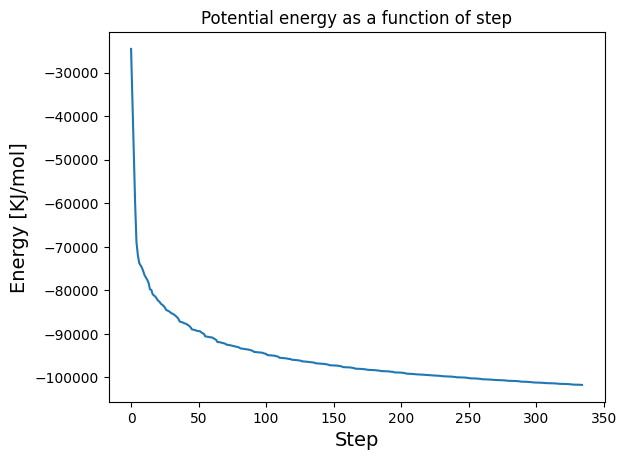

In [48]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data=np.loadtxt("00-em/potential.xvg",comments=["#","@"])
step=data[:,0] #assign the first column of data to the variable step
energy=data[:,1] #assign the second column of data to the variable potential
plt.plot(step,energy) #plot the function potential(data)
plt.xlabel("Step",size=14) #assign the x label
plt.ylabel("Energy [KJ/mol]",size=14) #assign the y label
plt.title("Potential energy as a function of step"); #assign a title
#save the figure in png format with a resolution of 300 dot per inch "dpi"
plt.savefig("00-em/potential.png",format="png", dpi=300)

## Position Restraint

EM ensured that we have a reasonable starting structure, in terms of geometry and solvent orientation.

To begin real dynamics, we must equilibrate the solvent and ions around the protein.

If we were to attempt unrestrained dynamics at this point, the system may collapse. The reason is that the solvent is mostly optimized within itself, and not necessarily with the solute.

It needs to be brought to the temperature we wish to simulate.



In [49]:
%%bash
mkdir 01-posres

Input files required to run a Molecular Dynamics (MD) simulation are again
a molecular structure, a topology and a files with simulation settings:
1. (minimized) structure file (`minimized.gro`)
1. topology file (`penetratin.top`)
1. molecular dynamics parameters file (`posre.mdp/md.mdp`)

Remember that `posre.itp` file that `pdb2gmx` generated a long time ago? We're going to use it now. The purpose of posre.itp is to apply a position restraining force on the heavy atoms of the protein (anything that is not hydrogen). Movement is permitted, but the particle will feel a harmonic potential that will tend to keep it around the initial position.

$V_{pr}(r_i)=\frac{1}{2}k_{pr}|r_i-R_i|^2$

Where $R_i$ is the reference position and the $k_{pr}$ is the Force constant proportional to the strenght of the potential applied.

<img src="https://manual.gromacs.org/current/_images/f-pr.png" width="500" align="center">



In [50]:
!cat system/penetratin_posre.itp

; In this topology include file, you will find position restraint
; entries for all the heavy atoms in your original pdb file.
; This means that all the protons which were added by pdb2gmx are
; not restrained.

[ position_restraints ]
; atom  type      fx      fy      fz
     1     1  1000  1000  1000
     5     1  1000  1000  1000
     7     1  1000  1000  1000
    10     1  1000  1000  1000
    13     1  1000  1000  1000
    16     1  1000  1000  1000
    18     1  1000  1000  1000
    19     1  1000  1000  1000
    22     1  1000  1000  1000
    25     1  1000  1000  1000
    26     1  1000  1000  1000
    27     1  1000  1000  1000
    29     1  1000  1000  1000
    31     1  1000  1000  1000
    34     1  1000  1000  1000
    37     1  1000  1000  1000
    38     1  1000  1000  1000
    39     1  1000  1000  1000
    42     1  1000  1000  1000
    43     1  1000  1000  1000
    44     1  1000  1000  1000
    46     1  1000  1000  1000
    48     1  1000  1000  1000
    50     1  

The utility of position restraints is that they allow us to equilibrate our solvent around our protein, without the added variable of structural changes in the protein.

The origin of the position restraints (the coordinates at which the restraint potential is zero) is provided via a coordinate file passed to the -r option of `grompp`.

We’ll use the file `posre.mdp` which contains the parameters for a molecular dynamics simulation with position
restraints.

Have a look to posre.mdp:

In [51]:
!cat data/mdp/posre.mdp

include                  = 
define                   = -DPOSRES  ;Include the position restraint file
integrator               = md	;Select the leap-frog algorithm to integrate the equation of motion
dt                       = 0.001  ;Step to integrate the equation of motion
nsteps                   = 20000  ;Maximum number of steps to integrate or minimize, -1 is no maximum
init_step                = 0 
simulation_part          = 1 
comm-mode                = Linear ; Remove center of mass translational velocity 
nstcomm                  = 1 
comm-grps                = system

emtol                    = 10
emstep                   = 0.01
niter                    = 20
fcstep                   = 0
nstcgsteep               = 1000
nbfgscorr                = 10

nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
nstlog                   = 100
nstcalcenergy            = 10
nstenergy                = 10
nstxtcout                = 100

cutoff-scheme        

In [52]:
!tail -n 29 system/penetratin.top


; Include Position restraint file
#ifdef POSRES
#include "penetratin_posre.itp"
#endif

; Include water topology
#include "amber99sb-ildn.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif

; Include topology for ions
#include "amber99sb-ildn.ff/ions.itp"

[ system ]
; Name
Penetratin-Silica Umbrella simulation in water

[ molecules ]
; Compound        #mols
Protein_chain_B     1
SOL         2085
NA               6
CL               13


We will perform a Molecular dynamic simulation integrating the equation of motion with the leap frog algorithm `integrator=md`. We have to choose the step of integration for the equation of motion `dt=` and define the total numbers of step of simulation `nsteps`.

How do I calculate the time for which I am simulating?

$t_{tot}=dt*nsteps$

where $t_{tot}$ is the total simulation time, dt is the integration step and nsteps is the total number of steps

In [53]:
dt=0.01 #step of integration
nsteps=20000 #total number of steps
tot=dt*nsteps #total simulation time
print(f"The total simulation time will be {tot}, which is the unit of measure?")

The total simulation time will be 200.0, which is the unit of measure?


<div class="alert alert-block alert-info"><center><b> What about the initial velocities?</b></center><div>

There are two possible strategies
1. Start with initial velocity equal to zero for all the atoms in the simulation environment and coupling with a thermostat
1. Assign to the atoms initial velocity so that the distribution of the velocity is equal to a Maxwell-Boltzmann distribution at a given temperature $p(\it{v}_i)$


<div><center>$p(\it{v}_i)=\sqrt{\frac{m_i}{2\pi kT}}\exp{\left(- \frac{m_i\it{v}_{i}^2}{2kT}\right)}$</center> </div>
<br>


<div class="alert alert-block alert-danger"><center><b>ATTENTION! NERD TIME</b></center>
    
To accomplish this second possibility, normally distributed random numbers are generated by adding twelve random numbers $R_K$ in the range 0 ≤$R_K$< 1 and subtracting 6.0 from their sum. The result is then multiplied by the standard deviation of the velocity distribution $\sqrt{\frac{𝑘𝑇}{𝑚_𝑖}}$. Since the resulting total energy will not correspond exactly to the required temperature $T$, a correction is made: first the center-of-mass motion is removed and then all velocities are scaled so that the total energy corresponds exactly to $T$.

 </div>



In [54]:
%%bash
gmx grompp -f data/mdp/posre.mdp -c 00-em/em.gro -r 00-em/em.gro -p system/penetratin.top -o 01-posres/posres.tpr

Setting the LD random seed to -1350598661

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning all bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning all bonds into constraints...

Velocities were taken from a Maxwell distribution at 300 K

The center of mass of the position restraint coord's is  3.472  3.417  1.592

The center of mass of the position restraint coord's is  3.472  3.417  1.592
Analysing residue names:
There are:    16    Protein residues
There are:  2085      Water residues
There are:    19        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determini

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

<div class="alert alert-block alert-warning"><b>Important observation</b><br> In this case Gromacs failed, what we can do? <br>Rise the hand and ask to the professor/assistant for help? <br> Or read the output, solve the problem and enter in the engineer's adulthood?<br>So read the output and try to undersand the problem</div>
<br>

**NB** Some GROMACS version cannot experience this warning, however this hint is also valid

**P.S.** Seeking advice from classroom teachers is essential and strongly recommended and encouraged. Paradoxically, however, asking for advice after trying to solve the problem and reading the terminal is even better!

In [55]:
%%bash
gmx grompp -f data/mdp/posre.mdp -c 00-em/em.gro -r 00-em/em.gro -p system/penetratin.top -o 01-posres/posres.tpr -maxwarn 2

Setting the LD random seed to -8388609

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning all bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning all bonds into constraints...

Velocities were taken from a Maxwell distribution at 300 K

The center of mass of the position restraint coord's is  3.472  3.417  1.592

The center of mass of the position restraint coord's is  3.472  3.417  1.592
Analysing residue names:
There are:    16    Protein residues
There are:  2085      Water residues
There are:    19        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining 

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [56]:
!gmx mdrun -s 01-posres/posres.tpr -deffnm 01-posres/posres -v -nt 12

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

<div class="alert alert-block alert-info"><center><b> Is the system well equilibrated in terms of temperature? And in terms of pressure?</b></center><div>

In [57]:
! echo -e "Temperature \n Pressure \n 0" | gmx energy -f 01-posres/posres.edr -o 01-posres/Temp_Press.xvg

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

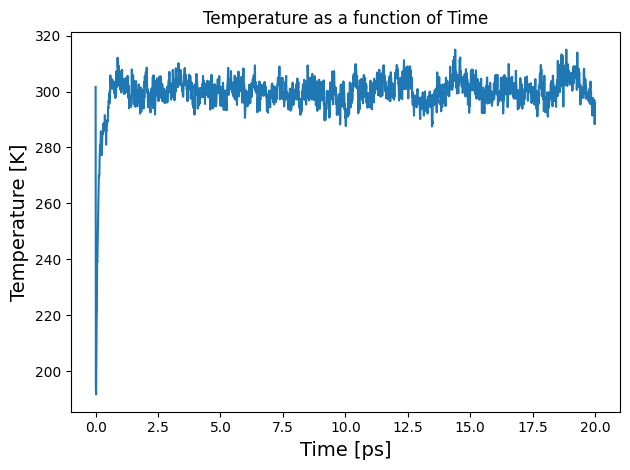

In [58]:
data=np.loadtxt("01-posres/Temp_Press.xvg",comments=["#","@"])
time=data[:,0] #assign the first column of data to the variable step
temp=data[:,1] #assign the second column of data to the variable potential
pressure=data[:,2] #assign the second column of data to the variable pressure
plt.plot(time,temp)
plt.xlabel("Time [ps]",size=14)
plt.ylabel("Temperature [K]",size=14)
plt.title("Temperature as a function of Time")
plt.tight_layout()

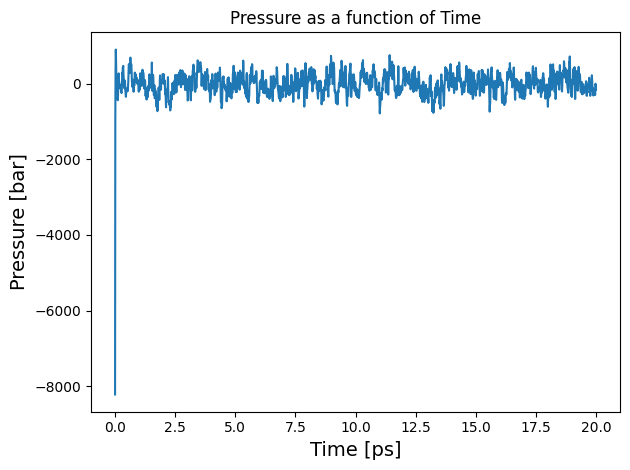

In [59]:
plt.plot(time,pressure)
plt.xlabel("Time [ps]",size=14)
plt.ylabel("Pressure [bar]",size=14)
plt.title("Pressure as a function of Time")
plt.tight_layout()

In [60]:
! echo -e "Density \n 0" | gmx energy -f 01-posres/posres.edr -o 01-posres/density.xvg

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

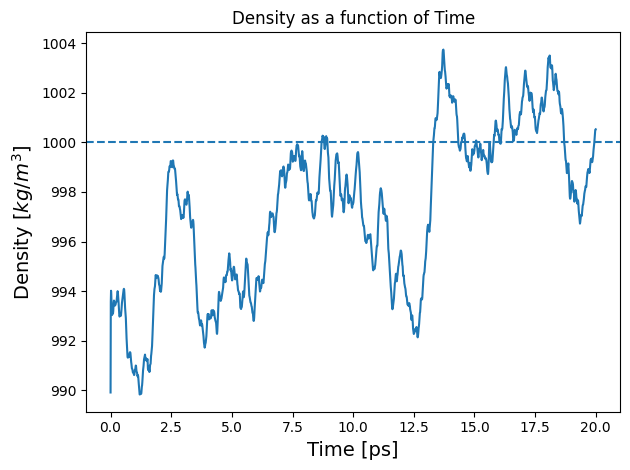

In [61]:
data=np.loadtxt("01-posres/density.xvg",comments=["#","@"])
time=data[:,0] #assign the first column of data to the variable time
density=data[:,1] #assign the second column of data to the variable Density
plt.plot(time,density)
plt.xlabel("Time [ps]",size=14)
plt.ylabel("Density [$kg/m^3$]",size=14)
plt.axhline(1000,time[0],time[-1],ls="--")
plt.title("Density as a function of Time")
plt.tight_layout()

<div class="alert alert-block alert-info"><center><b> How to plot two diagrams in a single subplot? </b></center><div>

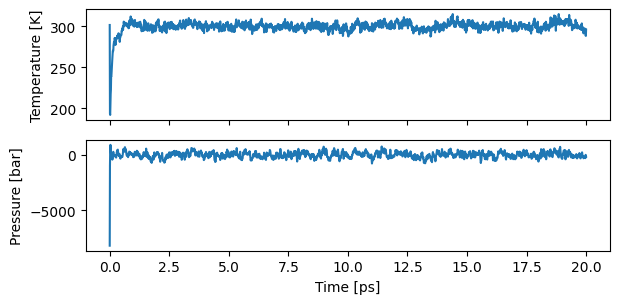

In [62]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data=np.loadtxt("01-posres/Temp_Press.xvg",comments=["#","@"])
time=data[:,0] #assign the first column of data to the variable step
temp=data[:,1] #assign the second column of data to the variable potential
press=data[:,2] #assign the second column of data to the variable potential

plot,axes=plt.subplots(2,1,sharex=True,figsize=(16/2.54,8/2.54)) #plot the function potential(data)
# note: size expressed in inches ~= cm / 2.54
axes[0].plot(time,temp)
axes[1].plot(time,press)
axes[1].set_xlabel("Time [ps]",fontsize=10) #assign the x label
axes[0].set_ylabel("Temperature [K]",fontsize=10) #assign the y label
axes[1].set_ylabel("Pressure [bar]",fontsize=10) #assign the y label
#save the figure in png format with a resolution of 300 dot per inch "dpi"
plot.tight_layout()
plot.savefig("01-posres/subplot_temp_press.png",format="png", dpi=300)

## Production without position restraints

Upon completion of the equilibration phase, the system is now well-equilibrated at the desired temperature and pressure. We are now ready to release the position restraints and run production MD for data collection.

***If you have not run the equilibration phase, copy the files from the previous part of the notebook with the following cell:***

In [63]:
%%bash
mkdir -p 01-posres/
cp -r data/part_3/01-posres/* 01-posres/

Return at the root of your working directory, create a folder for the molecular dynamics production:

In [64]:
!mkdir 02-prod

In [65]:
!cat data/mdp/md.mdp

include                  = 
define                   = 
integrator               = md
dt                       = 0.002
nsteps                   = 25000
init_step                = 0
simulation_part          = 1
comm-mode                = Linear
nstcomm                  = 1
comm-grps                = system

emtol                    = 10
emstep                   = 0.01
niter                    = 20
fcstep                   = 0
nstcgsteep               = 1000
nbfgscorr                = 10

nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
nstlog                   = 10
nstcalcenergy            = 10
nstenergy                = 10
nstxtcout                = 10

cutoff-scheme            = Verlet
nstlist                  = 20
ns-type                  = Grid
pbc                      = xyz
rlist                    = 1.0
coulombtype              = pme
coulomb-modifier         = Potential-shift-Verlet
rcoulomb-switch          = 1.0
rcoulomb                 = 1.0

Create the tpr and run the simulation: we will use the file “md.mdp” for molecular dynamics parameters which
do not include the position restraints of the previous step. Note that we will use the structure file coming from
the previous equilibration with position restraints, i.e. posre.gro

In [66]:
!gmx grompp -f data/mdp/md.mdp -c  01-posres/posres.gro -p system/penetratin.top -o 02-prod/prod.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [67]:
!gmx mdrun -deffnm 02-prod/prod -s 02-prod/prod.tpr -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In [68]:
!pwd

/content


## Visualize the trajectory

In [69]:
import nglview as nv
traj = nv.SimpletrajTrajectory("02-prod/prod.xtc", "02-prod/prod.gro")
view_pbc = nv.show_simpletraj(traj)
view_pbc.add_representation("ball+stick",selection="water")
view_pbc.center("System")
view_pbc

NGLWidget(max_frame=2500)

In [70]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [71]:
from google.colab import output
output.disable_custom_widget_manager()

The trajectory file that is obtained as a result of the simulation, if directly loaded onto a visualization program has artifacts due to the presence of the periodic conditions.

In fact since the bonds are created heuristically at the beginning by the program, if some atoms of the molecule exit from one side and re-enter from the opposite side the visualization program always considers them joined.

Mind you, this is not an error in the trajectory, it is due to the presence of the periodic conditions. To "reconstruct" molecules "broken" due to the periodic conditions one uses the gromacs program `gmx trjconv`, which is generally used to manipulate trajectory files in the various gromacs formats (`.trr`, `.xtc`, `.pdb`).


In [72]:
!gmx trjconv -h

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [73]:
!echo -e "0 \n" | gmx trjconv -s 02-prod/prod.tpr -f 02-prod/prod.xtc -o 02-prod/noPBC.xtc -pbc mol -ur compact

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [74]:
import nglview as nv
traj_nopbc = nv.SimpletrajTrajectory("02-prod/noPBC.xtc", "02-prod/prod.gro")
view_nopbc = nv.show_simpletraj(traj_nopbc)
view_nopbc.add_representation("ball+stick",selection="water")
view_nopbc.center("sytem")
view_nopbc

NGLWidget(max_frame=2500)

As we saw in class, in reality, to study protein folding and phenomena at the molecular scale, it is necessary to simulate for orders of tens of nanoseconds or even microsends.

Usually at the end of a simulation, certain quantities such as the RMSD (which we will see in the next part) are observed to assess the convergence of the simulations.

In the case that a simulation has not converged, it is possible to extend an existing simulation without having to start it all over again.

To extend an existing simulation it is possible to follow diverse approach.

One is to build a new `.tpr` with the `.gro` file coming as an output of the previous simulation and run another production.

Another approach is to overwrite the directive nsteps in the existing `.tpr` file and "extend" the existing trajectory.

To overwrite the number of steps one can employ the command

**`gmx convert-tpr -s "old.tpr" -nsteps "number of steps"`**

or

employ the option `-nsteps` in the command **`gmx mdrun`** to perform additional steps.

In both case the command **`gmx mdrun`** must be lunched with the `-cpi` option. `-cpi` option takes as input a check point file (`.cpt`).

**NB** The check point file (`.cpt`) can also be employed to conclude a simulation that for some reason, such computer shutdown, has not concluded the total number of steps.

Let's extend the previous simulation in order to have a trajectory of 10 ns.

If the `dt=0.002` how many steps we must perform in order to have 10 ns of simulation?

In [75]:
!gmx convert-tpr -s 02-prod/prod.tpr -nsteps 5000000 -o 02-prod/prod_ext.tpr

           :-) GROMACS - gmx convert-tpr, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff          

In [ ]:
!gmx mdrun -deffnm 02-prod/prod -cpi 02-prod/prod.cpt -s 02-prod/prod_ext.tpr -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

# PART 4 - Analysis

In this section, we will see some basic analysis that can be done on the result of a MD simulation.
We will do the analysis on the data contained in the folder `data/part_4`. We will need a tpr, so let's create it.

Let's create a working directory and copy those data:

In [ ]:
%%bash
mkdir -p 03-analysis
cp data/part_4/* 03-analysis/
cd 03-analysis
gmx grompp -f dummy.mdp -c penetratin.pdb -p penetratin.top -o topol.tpr > /dev/null 2>&1

<div class="alert alert-block alert-warning"><b><center>WARNING</center></b><br>
    As you have noticed, we have created a new file <b>".tpr"</b> in the previous cell. This is due to the fact that the <b>".tpr"</b>  file, unlike most of the other formats produced by gromacs ('xtc', 'gro', 'trr' etc...) is linked to the version of the software with which it was created. In other words, a <b>".tpr"</b>  created with the <b>"gromacs 2020"</b> version can only be read by <b>"gromacs 2020"</b> and not by the version of <b>"gromacs 2021"</b>.
</div>

First, import and install necessary packages necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def convert_image(f="plot.eps",o="plot.png"):
    '''
    Function that allows you to convert a file from esp format to png format
    '''
    from PIL import Image
    eps_image = Image.open(f)
    eps_image.load(scale=10)
    eps_image.save(o)

## RMSD

The root-mean-square deviation (RMSD) is a measure of the average distance between the atoms (usually C$\alpha$s or the backbone) of superimposed proteins. Typically RMSD is used as a quantitative measure of similarity between two or more protein structures. In the case of Molecular Dynamics simulations, one of the first analysis that is usually done is the observation of RMSD of protein atoms with respect to a target conformation over time:

$$RMSD (t) = \sqrt{\frac{1}{N}\sum^{N}_{i=1}{\left(r_{i}(t)-r_{ref}\right)^2}}$$

where N is the number of atoms that you are considering (e.g., the total number of C$\alpha$s).

If RMSD is computed using the first frame as reference, we can quantify possible conformational changes from the initial structure used in the simulation. Moreover, we can have a first information about simulation convegernce if the RMSD stabilizes.

Consider a 500 ns long simulation and the RMSD with respect to the initial conformation. The RMSD stabilized around 1 nm starting from 100 ns. Can you say that the conformations at 450 ns and 200 ns are for sure similar?

The answer is no!
That information suggests you that the conformation are similar, but the actual information is that they are "equally distant" from the initial configuration of the system (reference frame). Therefore, it can happen that:

$$ RMSD(200ns, 450ns) >> RMSD(0ns, 450ns) = RMSD(0ns, 200ns)$$

We can test deeper the convergence of the simulation by using another frame as reference, such as the frame at 450ns. If the RMSD is stable and "low" starting from 100 ns (i.e., much lower than the one with respect to the initial frame), then we can be more confident about simulation convergence.

**Note**

The RMSD can be computed to other, non-protein molecules, such as small organic molecules, i.e., ligands. For instance, if we fit the trajectory on the protein and measure the RMSD of the ligand, we obtain information about the ligand position within the protein binding cleft.

In [ ]:
!gmx rms -h

In [ ]:
%%bash
cd 03-analysis/
echo -e "Backbone\nBackbone" | gmx rms -s penetratin.pdb -f penetratin.xtc -o rmsd.xvg -tu ns
echo -e "System" | gmx trjconv -s topol.tpr -f penetratin.xtc -dump 9 -o struct9ns.pdb -tu ns
echo -e "Backbone\nBackbone" | gmx rms -s struct9ns.pdb -f penetratin.xtc -o rmsd_9ns.xvg -tu ns

In [ ]:
# Load your data
time, rmsd = np.loadtxt('03-analysis/rmsd.xvg',comments=['@','#'],unpack=True)
_, rmsd9 = np.loadtxt('03-analysis/rmsd_9ns.xvg',comments=['@','#'],unpack=True)

# Prepare the figure
fig = plt.figure()
ax = fig.add_subplot(111,)

# Plot your data
ax.plot(time,rmsd,label='Ref: 0 ns',c='k')
ax.plot(time,rmsd9,label='Ref: 9 ns',c='r')

# Adjust the plot and personalize
ax.set_xlim(time[0],time[-1])
m = np.max(np.concatenate((rmsd,rmsd9)))*1.05
ax.set_ylim(0,m)
ax.set_xlabel(r"Time [ns]")
ax.set_ylabel(r"RMSD [nm]")
ax.legend(frameon=False)

# This allows you to adjust the figure limits to make your figure nice
# (Recommended but not compulsory)
fig.tight_layout()

# Now, save the plot (if you want)
fig.savefig('03-analysis/rmsd_comparison.jpg',dpi=300,facecolor='white')

## RMSF

The root-mean-square fluctuation (RMSF) from the average is a measure that allows you to quantify the fluctuation of an atom (or a group of atoms) during time.

In the case of Molecular Dynamics simulations, the RMSF of protein residues is computed to identify the most stable and the most flexible parts of the protein structures. Usually, non-structured regions are the most flexible. The RMSF is usually computed as an average for each residue or is computed considering the C$\alpha$s as representative of the whole residues.

The RMSF for the i-th atom is defined as:

$$RMSF = \sqrt{\frac{1}{N}\sum^{N}_{t=1}{\left(r_{i}(t)-r_{ref}\right)^2}}$$

where N is the total number of frames in the trajectory.

In [ ]:
!gmx rmsf -h

In [ ]:
%%bash
cd 03-analysis/
echo "C-alpha" | gmx rmsf -f penetratin.xtc -s topol.tpr -o rmsf.xvg -res

In [ ]:
!cat 03-analysis/rmsf.xvg

In [ ]:
# Load your data
res, rmsf = np.loadtxt('03-analysis/rmsf.xvg',comments=['@','#'],unpack=True)

# Prepare the figure
fig = plt.figure()
ax = fig.add_subplot(111,)

# Plot your data
ax.plot(res,rmsf,c='k')

# Adjust the plot and personalize
ax.set_xlim(res[0],res[-1])
m = np.max(rmsf)*1.05
ax.set_ylim(0,m)
ax.set_xlabel(r"Residue number")
ax.set_ylabel(r"RMSF [nm]")

# This allows you to adjust the figure limits to make your figure nice
# (Recommended but not compulsory)
fig.tight_layout()

# Now, save the plot (if you want)
fig.savefig('03-analysis/rmsf.png',dpi=300,facecolor='white')

**Note**
You can use the rmsf command of GROMACS to generate an average configuration of the protein in a certain portion of the trajectory. This configuration can be used as reference in the RMSD analysis.

Suppose that you take the average configuration in the trajectory from 400ns to 450ns: if the RMSD is "low" and stable also berfore (and after) that interval, it means that during the equilibrium trajectory the conformations are equally distant from the average of time \[400ns; 450ns\]

In [ ]:
%%bash
cd 03-analysis/
echo "Protein" | gmx rmsf -f penetratin.xtc -s topol.tpr -o rmsf_eq.xvg -ox average.pdb -b 8000 -e 9000
echo -e "Backbone\nBackbone" | gmx rms -s average.pdb -f penetratin.xtc -o rmsd_av.xvg -tu ns

In [ ]:
time, rmsd = np.loadtxt('03-analysis/rmsd_av.xvg',comments=['@','#'],unpack=True)
_, rmsd50 = np.loadtxt('03-analysis/rmsd_9ns.xvg',comments=['@','#'],unpack=True)
_, rmsd0 = np.loadtxt('03-analysis/rmsd.xvg',comments=['@','#'],unpack=True)
fig = plt.figure()
ax = fig.add_subplot(111,)
ax.plot(time,rmsd0,c='k',label='Ref: 0 ns')
ax.plot(time,rmsd50,c='r',label='Ref: 9 ns')
ax.plot(time,rmsd,c='b',label='Ref: [8-9]ns')
ax.set_xlim(time[0],time[-1])
m = np.max(np.concatenate((rmsd,rmsd50,rmsd0)))*1.05
ax.set_ylim(0,m)
ax.set_xlabel(r"Time [ns]")
ax.set_ylabel(r"RMSD [nm]")
ax.legend()
fig.tight_layout()
fig.savefig('03-analysis/rmsd_average.png',dpi=300,facecolor='white')

## Radius of Gyration

Radius of gyration or gyradius of a body about the axis of rotation is defined as the radial distance to a point which would have a moment of inertia the same as the body's actual distribution of mass, if the total mass of the body were concentrated there.
In polymer physics, the radius of gyration is used to describe the dimensions of a polymer chain. The radius of gyration of a particular molecule at a given time is defined as:

$$ R_{\mathrm {g} }\ =\ \sqrt{{\frac {1}{N}}\sum _{i=1}^{N}\left(\mathbf {r} _{i}-\mathbf {r} _{\mathrm {COM} }\right)^{2}}$$

In [ ]:
!gmx gyrate -h

In [ ]:
%%bash
cd 03-analysis/
echo "Protein" | gmx gyrate -f penetratin.xtc -s topol.tpr -o rog.xvg

Let's make thing more difficult. Plot both the time distribution of the radius of gyration and an histogram distribution

In [ ]:
time, rog,_,_,_ = np.loadtxt('03-analysis/rog.xvg',comments=['@','#'],unpack=True)
time /= 1000 # gmx gyrate gives the time in ps
fig = plt.figure(figsize=(6,3))
# in time
ax1 = fig.add_subplot(121,)
ax1.plot(time,rog,c='k')
ax1.set_xlim(time[0],time[-1])
M = np.max(rog)*1.05
m = np.min(rog)*0.95
ax1.set_ylim(m,M)
ax1.set_xlabel(r"Time [ns]")
ax1.set_ylabel(r"$R_g$ [nm]")

# histogram
ax2 = fig.add_subplot(122,)
ax2.hist(rog,color='k',density=True,alpha=0.5)
ax2.set_ylabel(r"Probability density")
ax2.set_xlabel(r"$R_g$ [nm]")
fig.tight_layout()
fig.savefig('03-analysis/radius_of_gyration.png',dpi=300,facecolor='white')

## Ramachandran plot

The allowed combinations of torsional angles ψ and φ for a couple of residues are illustrated in the Ramachandran plot. It serves to represent allowed and disallowed regions of the two torsional angles of each peptide bond in a polypeptide chain.

To compute the torsional angles in GROMACS we need:
1. a tpr file containing the information about all the atoms in the system
2. the coordinates of the system. It can be a single structure or an ensemble (a pdb with multiple frames or an xtc)

In [ ]:
!gmx rama -f 03-analysis/penetratin.xtc -s 03-analysis/topol.tpr -o 03-analysis/rama.xvg

Now, the formatting of the output file is:

$\phi$ $\psi$ res1(time 1)

$\phi$ $\psi$ res2(time 1)

$\phi$ $\psi$ res3(time 1)

$\phi$ $\psi$ res4(time 1)

$\phi$ $\psi$ res1(time 2)

$\phi$ $\psi$ res2(time 2)

...

$\phi$ $\psi$ res4(time N-1)

$\phi$ $\psi$ res1(time N)

$\phi$ $\psi$ res2(time N)

$\phi$ $\psi$ res3(time N)

$\phi$ $\psi$ res4(time N)

**No need to worry:**
Here we have an example of analysis, so you can extract pieces of cose to use in your analysis. Use them wisely!

In [ ]:
# Load data
# You have to load separately floating point numbers and string
phi, psi = np.loadtxt('03-analysis/rama.xvg',comments=['@','#'],usecols=(0,1),unpack=True)
residues = np.loadtxt('03-analysis/rama.xvg',comments=['@','#'],usecols=(2),dtype=str)

# This line searches all the points in the array where the first residue of the protein is present
# Therefore, it contains the information to separate information of different frames
delimiters = np.squeeze(np.argwhere(residues == residues[0]))

In [ ]:
from matplotlib.lines import Line2D # For the legend
from MDAnalysis.analysis.data.filenames import Rama_ref
import time

The data in `Rama_ref` contains information about dihedral $\phi$ and $\psi$ angles on a set of 500 PDB structures taken from [Lovell2003](https://doi.org/https://doi.org/10.1002/prot.10286). This is a numpy array that can be used to create *Allowed* and *Generously Allowed* (which means that contain 90% and 99% of the data points) in the Ramachandran plot.

In [ ]:
from IPython import display
frames = [0,800]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,)
# Generate points in the plane to plot the Ramachandran regions
# THESE X,Y POINTS ARE CREATED IN ORDER TO BE COHERENT WITH DATA IN Rama_ref
# DO NOT MODIFY
X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
Z = np.load(Rama_ref)
# THE NUMBERS ON LEVELS ARE DEFINED TO PLOT THE ALLOWED AND GENEROUSLY ALLOWED REGIONS
# DO NOT MODIFY
c = ax.contourf(X, Y, Z, levels=[1, 17, 15000],colors = ['#A1D4FF', '#35A1FF'])

# Set the limits of torsional angles
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
ax.set_xlabel(r"$\phi$ [°]")
ax.set_ylabel(r"$\psi$ [°]")

#Personalize it with a legend
custom_lines = [Line2D([0], [0], color='#A1D4FF', lw=8),
                Line2D([0], [0], color='#35A1FF', lw=8)]
ax.legend(custom_lines, ['99%', '90%'],loc='lower center',frameon=False)
colors=['tomato','k']
plt.ion()
for col,frame in zip(colors,frames):
    ax.scatter(phi[delimiters[frame]:delimiters[frame+1]],psi[delimiters[frame]:delimiters[frame+1]],
              marker='o',s=20,c=col)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)
plt.show()


Do you remember what secondary structure is usually present in the region populated by in the above Ramachandran plot?

Is this coherent with our peptide?

## Distance between the extrema

In some molecular systems, the distance between two residues (or group of residues) is an important descriptor of the protein conformation.

Let's assume that there is loop of a protein that, with its movement, opens or closes a binding site. We might define the distance of this loop from the binding site and describe the site opening or closure in terms of such distance.

This was only a very basic example, but it stresses the fact that, in some cases, important information of the molecular systems can be described with simple metrics. Usually, in real life problems, the heard part is finding these metrics from the observation of the system trajectory (do you remember the lessons about metadynamics and collective variables?).

To make an example, let's compute the distance between the two extrema of our peptide. It can be done with GROMACS using the `gmx distance` command. To do so:
1. create an index containing the two groups from which you want to compute the distance
2. use the gromacs function with the option `-select 'com of group "[name group 1]" plus com of group "[name group 2]"`

**Note** that `com` stands for _center of mass_, which means you are computing the distances between the centres of mass of the two groups.

In [ ]:
%%bash
cd 03-analysis
echo "r 43
name 17 E1
r 56
name 18 E2
q" | gmx make_ndx -f penetratin.pdb -o index.ndx
gmx distance -f penetratin.xtc -s topol.tpr -select 'com of group "E1" plus com of group "E2"' \
-n index.ndx -oav distance.xvg

In [ ]:
time, d = np.loadtxt('03-analysis/distance.xvg',comments=['@','#'],unpack=True)
time = time/1000 # gmx distance gives output only in ps
fig = plt.figure(figsize=(6,3))
# in time
ax1 = fig.add_subplot(121,)
ax1.plot(time,d,c='k')
ax1.set_xlim(time[0],time[-1])
M = np.max(d)*1.05
m = np.min(d)*0.95
ax1.set_ylim(m,M)
ax1.set_xlabel(r"Time [ns]")
ax1.set_ylabel(r"$d_{ee}$ [nm]")

# histogram
ax2 = fig.add_subplot(122,)
ax2.hist(d,color='k',density=True,alpha=0.5)
ax2.set_ylabel(r"Probability density")
ax2.set_xlabel(r"$d_{ee}$ [nm]")
fig.tight_layout()
fig.savefig('03-analysis/distance.png',dpi=300,facecolor='white')

## Hydrogen Bonds

Hydrogen bond is a type of dipole-dipole attraction between molecules. It results from the attractive force between a hydrogen atom convalently bonded to a very elecctronegative atom such as N, O or F atom and another very elecctronegative atom.

The Hydrogen Bond analysis aims at identify the number and/or the duration of hydrogen bonds in a system of interest.

Hydrogen bonds are determined by `GROMACS` function **`gmx hbond`** based on two geometric features:
* the angle Hydrogen - Donor - Acceptor
* the distance Donor - Acceptor (or Hydrogen - Acceptor).

In [ ]:
!gmx hbond -h

Usully one can be interested in exploring the number of hydrogen bonds between the Protein and the solvent (Water) and the Protein with it-self

In [ ]:
%%bash
cd 03-analysis
echo -e "Protein \n Water \n " | gmx hbond -f penetratin.xtc -s topol.tpr -num hb_water_protein.xvg
echo -e "Protein \n Protein \n " | gmx hbond -f penetratin.xtc -s topol.tpr -num hb_protein_protein.xvg

In [ ]:
time, hb_protein_water = np.loadtxt('03-analysis/hb_water_protein.xvg',comments=['@','#'],unpack=True)
_, hb_protein_protein = np.loadtxt('03-analysis/hb_protein_protein.xvg',comments=['@','#'],unpack=True)
time /= 1000

fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(131,)
ax2 = fig.add_subplot(132,sharex = ax1)
ax3 = fig.add_subplot(133,)
ax1.plot(time,hb_protein_water,c='b')
ax2.plot(time,hb_protein_protein,c='r')
ax3.hist(hb_protein_water,color='b',density=True)
ax3.hist(hb_protein_protein,color='r',density=True)
ax1.set_xlim(time[0],time[-1])
ax1.set_xlabel(r"Time [ns]")
ax2.set_xlabel(r"Time [ns]")
ax3.set_xlabel(r"# HB")
ax1.set_ylabel(r"# HB")
ax2.set_ylabel(r"# HB")
ax3.set_ylabel("Probability density")
ax1.set_title('Water-Protein')
ax2.set_title('Protein-Protein')
m = np.min(np.concatenate((hb_protein_water,hb_protein_protein)))*0.95
M = np.max(np.concatenate((hb_protein_water,hb_protein_protein)))*1.05
ax3.set_xlim(m,M)
fig.tight_layout()
fig.savefig('03-analysis/hydrogen_bond.png',dpi=300,facecolor='white')

## Secondary structures Assesment

Protein secondary structure is the three dimensional form of local segments of proteins and refers to the pattern of hydrogen bonds between the carboxyloxygen atoms and amino hydrogen in the peptide backbone.

<img src="https://github.com/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/imgs/SS.png?raw=1" width="400" align="center">


Different methodologies and program has been developed to assess the secondary structure from the 3D protein coordinates.

**`Gromacs`** employ the software **`DSSP`** integrated in the function **`gmx do_dssp`**.

The **`DSSP`** program works by calculating the most likely secondary structure assignment given the 3D structure of a protein.

It does this by reading the position of the atoms in a protein followed by calculation of the H-bond energy between all atoms.

The algorithm will discard any hydrogens present in the input structure and calculates the optimal hydrogen positions by placing them at 1.000 Å from the backbone N in the opposite direction from the backbone C=O bond.

The best two H-bonds for each atom are then used to determine the most likely class of secondary structure for each residue in the protein.

**`gmx do_dssp`** requires two necessary input:
1. **-f** the coordinates of the system. It can be a single structure or an ensemble (.xtc, .trr, .pdb)
1. **-s** the `.tpr` file containing the information about all the atoms in the system

In [ ]:
!gmx dssp -h

In [ ]:
%%bash
cd 03-analysis/
echo "Protein" | gmx dssp -s penetratin.pdb -f penetratin.xtc -tu ns -dt 0.1

Now, let's plot the secondary structure of the peptide along the simulation!

The ```gmx dssp``` command will produce a file called "dssp.dat" that contains the secondary structure of the protein along the simulation.

***Every line of the file is a frame of the trajectory and contains the secondary structure of each residue of the protein.***

gmx dssp allows using the DSSP algorithm (namely, by detecting specific patterns of hydrogen bonds between amino acid residues) to determine the secondary structure of a protein.

One-symbol secondary structure designations that are used in the output file:

    H — alpha-helix;
    B — residue in isolated beta-bridge;
    E — extended strand that participates in beta-ladder;
    G — 3_10-helix;
    I — pi-helix;
    P — kappa-helix (poly-proline II helix);
    S — bend;
    T — hydrogen-bonded turn;
    = — break;
    ~ — loop (no special secondary structure designation).

In [ ]:
# now let's plot the secondary structure every frame using a different color for each secondary structure

# Load the data
data = np.loadtxt('03-analysis/dssp.dat',comments=['@','#'],dtype=str)

# assign a number to each secondary structure
ss = {'H':0,'B':1,'E':2,'G':3,'I':4,'T':5,'S':6,'P':7,'=':8,'~':9}
ss_translation = {0:'Helix',1:'Beta-Sheet',2:'Strand',3:'3-10 helix',4:'Pi helix',5:'Hydrogen Bond Turn',6:'Bend',7:'Kappa-Helix',8:'Break',9:'Loop'}

# i want to replace all the H letters with 0, all the B letters with 1, etc.
data = [[ss[j] for j in i] for i in data]

In [ ]:
# plot the data as a heatmap
plt.figure(figsize=(10,5))

# Define a set of discrete colors
colors = [
    "#4E79A7",  # Steel Blue
    "#F28E2B",  # Mandarin Orange
    "#E15759",  # Coral Red
    "#76B7B2",  # Seafoam Green
    "#59A14F",  # Fresh Green
    "#EDC948",  # Golden Yellow
    "#AF7AA1",  # Soft Lavender
    "#FF9DA7",  # Pink Salmon
    "#9C755F",  # Mocha Brown
    "#BAB0AC"   # Warm Gray
]

# Create a colormap using the colors
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(colors, name='discrete')

plt.imshow(np.array(data).T, cmap=cmap, aspect='auto')
plt.xlabel("Frame")
plt.ylabel("Residue")
plt.title("Secondary structure")
# create a legend outside the plot using the ss keys as labels
plt.legend(handles=[plt.Line2D([0], [0], color=c, lw=4) for c in colors], labels=ss_translation.values(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('03-analysis/secondary_structure.png',dpi=300,facecolor='white')
plt.tight_layout()
